In diesem Notebook wird mit dem Efficient Net Modell von hugging face die Vorhersage der Bilder versucht.

Zuerst werden die später verwendeten Datasets importiert.

In [1]:
pip install torch datasets

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install transformers

Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install timm

Note: you may need to restart the kernel to use updated packages.


In [4]:
import timm
import torch
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
from torch import nn, optim
from tqdm import tqdm
import os
import shutil
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
im Hauptschritt wird Efficient Net geladen und angewendet.
Die Gesamtdauer des Modells wird gemessen und die Accuracy wird ausgegeben.

In [5]:
# Gerät konfigurieren
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Bildvorverarbeitung definieren
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Ändert die Grösse des Bildes
    transforms.ToTensor(),          # Konvertiert zu Tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalisierung
])

# Funktion, um unerwünschte Verzeichnisse zu entfernen
def clean_directories(directory):
    for root, dirs, _ in os.walk(directory):
        for dir_name in dirs:
            if dir_name.startswith("."):  # Versteckte Verzeichnisse wie .ipynb_checkpoints
                shutil.rmtree(os.path.join(root, dir_name))

# Daten bereinigen
train_dir = "./vehicles/train"
test_dir = "./vehicles/test"
clean_directories(train_dir)
clean_directories(test_dir)

# Daten laden
train_dataset = datasets.ImageFolder(
    train_dir,
    transform=transform,
    is_valid_file=lambda x: os.path.splitext(x)[1].lower() in [".jpg", ".jpeg", ".png", ".bmp"]
)

test_dataset = datasets.ImageFolder(
    test_dir,
    transform=transform,
    is_valid_file=lambda x: os.path.splitext(x)[1].lower() in [".jpg", ".jpeg", ".png", ".bmp"]
)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Modell laden und anpassen
model_name = "efficientnet_b0"
model = timm.create_model(model_name, pretrained=True, num_classes=len(train_dataset.classes))
model.to(device)

# Verlustfunktion und Optimierer definieren
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Trainingsfunktion
def train_model(model, train_loader, criterion, optimizer, device, epochs=5):
    model.train()
    for epoch in range(epochs):
        running_loss = 0.0
        for images, labels in tqdm(train_loader, desc=f"Training Epoch {epoch + 1}/{epochs}"):
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
        print(f"Epoch {epoch + 1}, Loss: {running_loss / len(train_loader):.4f}")

# Testfunktion
def test_model(model, test_loader, device):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in tqdm(test_loader, desc="Testing"):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    print(f"Test Accuracy: {100 * correct / total:.2f}%")

# Startzeit erfassen
start_time = time.time()

# Modell trainieren und testen
train_model(model, train_loader, criterion, optimizer, device, epochs=5)
test_model(model, test_loader, device)

# Endzeit erfassen
end_time = time.time()

# Dauer berechnen
training_duration = end_time - start_time
hours, rem = divmod(training_duration, 3600)
minutes, seconds = divmod(rem, 60)

print(f"Trainingsdauer: {int(hours)} Stunden, {int(minutes)} Minuten, {seconds:.2f} Sekunden")

Training Epoch 1/5: 100%|██████████| 12/12 [08:28<00:00, 42.35s/it]


Epoch 1, Loss: 1.3148


Training Epoch 2/5: 100%|██████████| 12/12 [08:17<00:00, 41.48s/it]


Epoch 2, Loss: 0.2401


Training Epoch 3/5: 100%|██████████| 12/12 [08:18<00:00, 41.53s/it]


Epoch 3, Loss: 0.2018


Training Epoch 4/5: 100%|██████████| 12/12 [08:04<00:00, 40.40s/it]


Epoch 4, Loss: 0.0822


Training Epoch 5/5: 100%|██████████| 12/12 [08:05<00:00, 40.48s/it]


Epoch 5, Loss: 0.1090


Testing: 100%|██████████| 2/2 [00:58<00:00, 29.18s/it]

Test Accuracy: 80.43%
Trainingsdauer: 0 Stunden, 42 Minuten, 13.32 Sekunden


Processing Test Data: 100%|██████████| 2/2 [00:57<00:00, 28.99s/it]


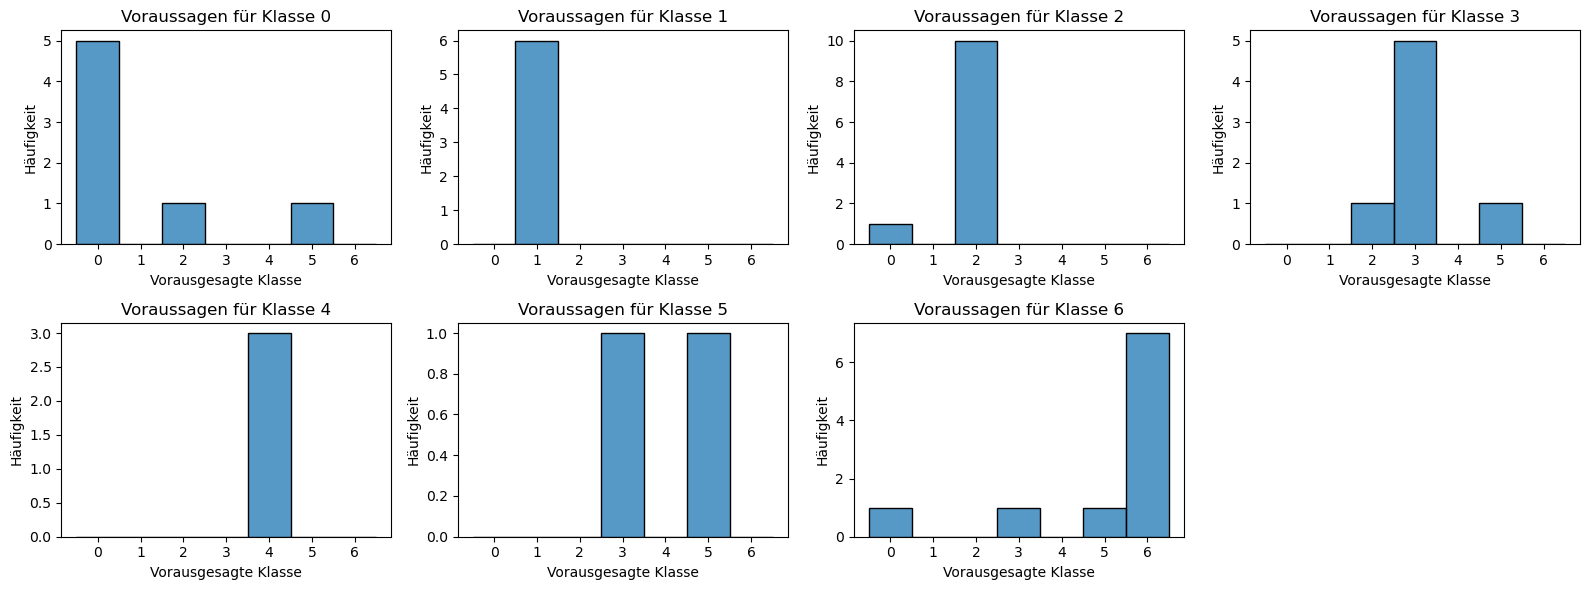

In [6]:
# Bereite die Testdaten vor (falls noch nicht passiert)
test_images = []
test_labels = []

for images, labels in tqdm(test_loader, desc="Processing Test Data"):
    test_images.append(images)
    test_labels.append(labels)

test_images = torch.cat(test_images).to(device)
test_labels = torch.cat(test_labels).to(device)

# Vorhersagen für die Testdaten
model.eval()
with torch.no_grad():
    outputs = model(test_images)
    predictions = outputs.cpu().numpy()

# Konvertiere One-Hot-Encoded Labels in eindimensionale Labels
true_labels = test_labels.cpu().numpy()

# Extrahiere die vorhergesagten Klassen (höchste Wahrscheinlichkeit)
predicted_labels = np.argmax(predictions, axis=1)

# Erstelle den DataFrame
results_df = pd.DataFrame({
    'True Label': true_labels,
    'Predicted Label': predicted_labels
})

# Plot der Vorhersagen nach Klassen
plt.figure(figsize=(16, 6))
num_classes = len(train_dataset.classes)  # Anzahl der Klassen aus dem Trainingsdatensatz
for i in range(num_classes):
    plt.subplot(2, (num_classes + 1) // 2, i + 1)
    sns.histplot(results_df[results_df['True Label'] == i]['Predicted Label'], bins=np.arange(num_classes + 1) - 0.5)
    plt.title(f'Voraussagen für Klasse {i}')
    plt.xlabel('Vorausgesagte Klasse')
    plt.ylabel('Häufigkeit')
    plt.xticks(range(num_classes))
plt.tight_layout()
plt.show()

In [ ]:
Neben der Accuracy und der Zeit wird noch eine Kunfusionsmatrix zum Vergleich erstellt.

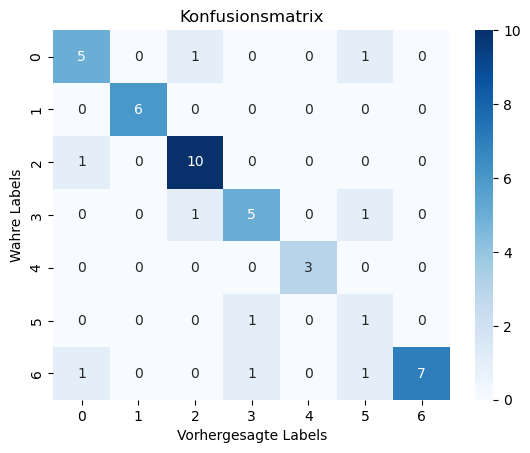

In [7]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

conf_matrix = confusion_matrix(true_labels, predicted_labels)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title("Konfusionsmatrix")
plt.xlabel("Vorhergesagte Labels")
plt.ylabel("Wahre Labels")
plt.show()